In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import pytz
from sklearn.metrics import mean_absolute_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg


# Prepare Data

## Import Data

In [16]:
def wrangel(filepath):
    # Read CSV file into DataFrame
    df = pd.read_csv(filepath, parse_dates=True, index_col="timestamp")
    
    # Localize Timezone
    df.index = df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")
    
    # Remove Outliers(less than 500)
    df["P2"] = df[df["P2"]<500]
    
    # Resample to 1H window, ffill missing value
    df = df["P2"].resample("1H").mean().fillna(method="ffill")
    
    return df

In [17]:
df = wrangel("F:Datasets/p2.csv")
df.head()

timestamp
2018-06-01 03:00:00+03:00    4.509000
2018-06-01 04:00:00+03:00    4.524928
2018-06-01 05:00:00+03:00    4.246471
2018-06-01 06:00:00+03:00    4.420000
2018-06-01 07:00:00+03:00    4.204348
Freq: H, Name: P2, dtype: float64

## Explore

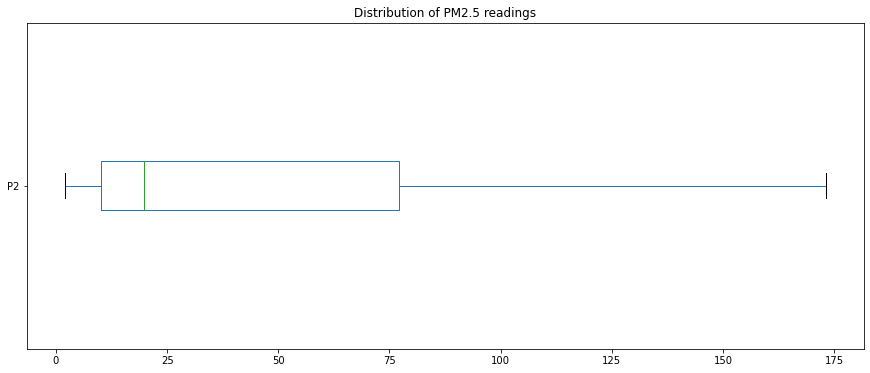

In [18]:
# Create a boxplot of the `"P2"` readings in `df`.
fig, ax = plt.subplots(figsize=(15,6))
df.plot(kind="box", vert=False,ax=ax, title="Distribution of PM2.5 readings");

Create a time series plot of the readings in `y`. Label your x-axis `"Date"` and your y-axis `"PM2.5 Level"`. Use the title `"Nairobi PM2.5 Levels"`.

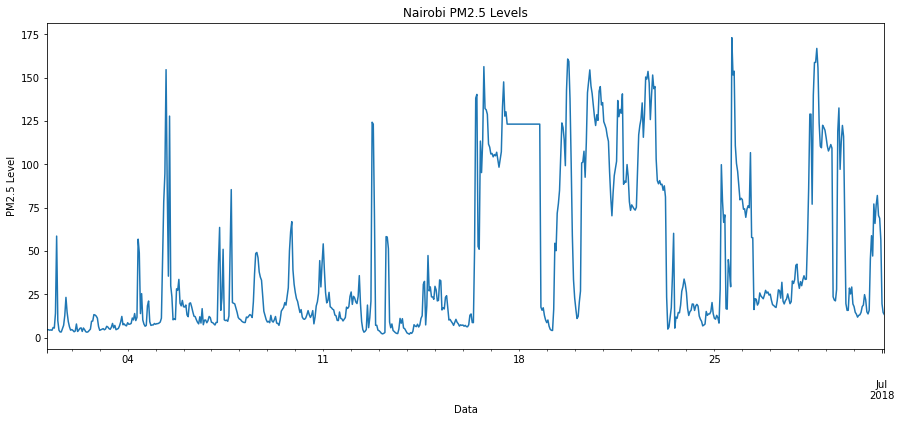

In [22]:
fig,ax = plt.subplots(figsize=(15,6))
df.plot(ax=ax, xlabel="Data", ylabel="PM2.5 Level", title="Nairobi PM2.5 Levels");

plot the rolling average of pm2.5 readings in df.

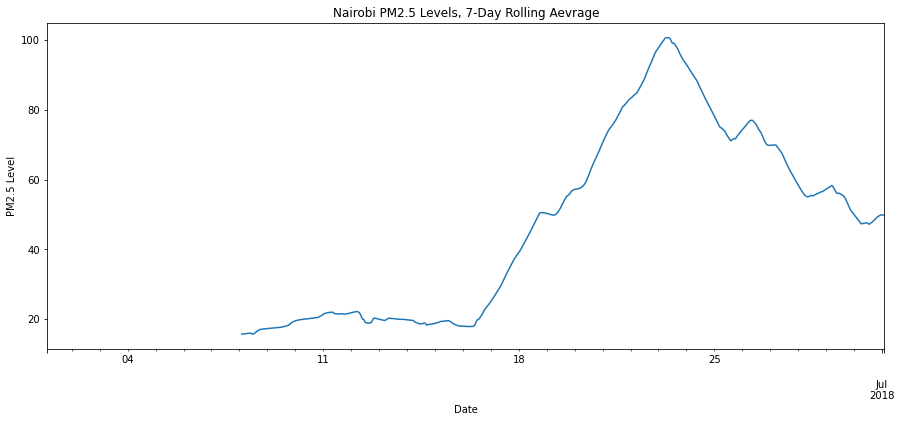

In [28]:
fig, ax = plt.subplots(figsize=(15,6))
# rolling average window
df.rolling(168).mean().plot(ax=ax, xlabel="Date", ylabel="PM2.5 Level",
                title="Nairobi PM2.5 Levels, 7-Day Rolling Aevrage");   # making rolling window of week (1 week =168 hrs)

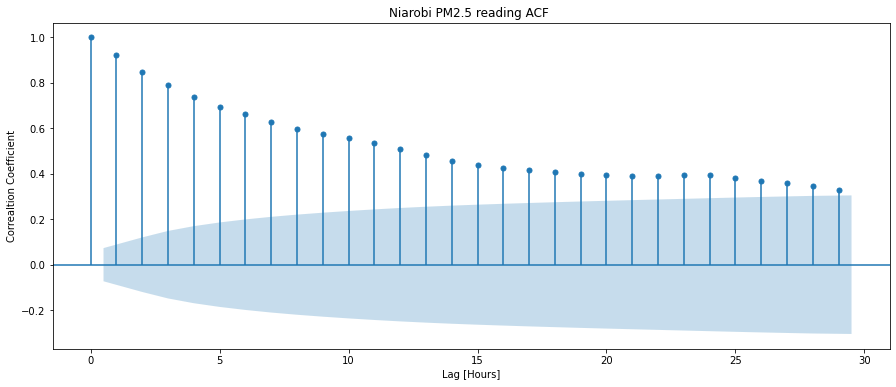

In [34]:
# plot_acf
fig, ax = plt.subplots(figsize=(15,6))
plot_acf(df, ax=ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Correaltion Coefficient")
plt.title("Niarobi PM2.5 reading ACF ");

plot_acf give us visual view of value of correlation coefficient of feature with different lag

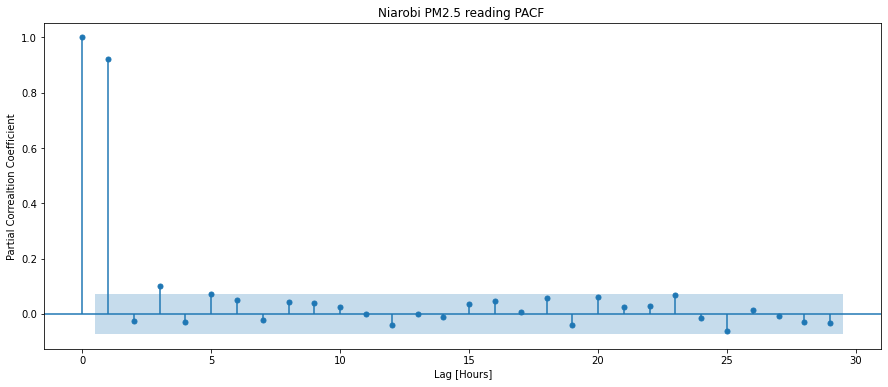

In [35]:
# plot_pacf
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(df, ax=ax)
plt.xlabel("Lag [Hours]")
plt.ylabel("Partial Correaltion Coefficient")
plt.title("Niarobi PM2.5 reading PACF ");

plot_pacf provide us the visual view of predictive power of features with different lags. It helps us in finding the number of features with lags we should select for our model.

## Split

In [40]:
# Train Test split
cutoff = int(len(df) * 0.9)
y_train = df.iloc[:cutoff]  # Training sample 90%
y_test = df.iloc[cutoff:]  # Test sample 10%

We are spliting trainin and test sample. Here we are not spliting our data in feature and target because we only have one feature which is our target vector.

# Build Model

## Baseline Model

In [49]:
y_mean = y_train.mean()
y_pred_baseline = [y_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean PM2.5 Reading:", round(y_mean,2))
print("MAE Baseline:", round(mae_baseline,2))

Mean PM2.5 Reading: 41.87
MAE Baseline: 38.36


Till now we only have one feature that is our PM2.5 reading which is our target vector, so we need feature on the basis of which we can train and predict our PM2.5 reading using our model.

We are using lag feature(PM2.5 Reading at previous timestamp) to predict the value. However the question is that how many lag feature do we need.
One way to find this is by looking at plot_pacf which provide us information about predictive power of feature with different lags, but here we are using different method which is called Hyperparameter Tuning. 

In Hyperparameter tuning we are going to use different hyperparameter setting (i.e.  with 2,4,6 or any lag feature).


## Iterate


You're going to use an AR model to predict PM2.5 readings, but which hyperparameter settings will give you the best performance? Use a `for` loop to train your AR model on using settings for `lag` from 1 to 30. Each time you train a new model, calculate its mean absolute error and append the result to the list `maes`. Then store your results in the Series `mae_series`. 

In [53]:
import warnings
warnings.filterwarnings("ignore")  # To ignore Warnings

p_params = range(1,31)
maes = []

for p in p_params:
    # Initialize and fit model
    model = AutoReg(y_train, lags=p).fit()
    y_pred_train = model.predict()
    # drop null values from prediction(like for "lag of 1" feature it has first value as NaN , so that their pred is also null)
    y_pred_train.dropna(inplace=True)
    # mean absolute error
    mae = mean_absolute_error(y_train.iloc[p:], y_pred_train) # we also have to drop columns from 
                                                                    #train set where prediction was null.
    maes.append(mae)
    
mae_series = pd.Series(maes, name="mae", index=p_params)
mae_series.head()

1    8.799528
2    8.811442
3    8.854208
4    8.864921
5    8.863743
Name: mae, dtype: float64

You have trained model for every setting for hyperparameter, now Look through the results in `mae_series` and determine what value for `p` provides the best performance.

In [79]:
best_p = mae_series.idxmin() # finding the index or row number(features with lag) for which mae value in min.
print(best_p)

11


8.657317518220308

however if we look at other mae's their is very slight difference in other mae's. it is very necessary for a data scientist to look for both the performance and resources (computational power). we can also select the model for which performace is good and it requires less resources.

For now we are still going with our best model because it also uses less resources

In [63]:
# Train
best_model = AutoReg(y_train, lags=best_p).fit()

In [65]:
# Before Evaluation, Have a look at residuals

y_train_resid = model.resid
y_train_resid.name="residual"
y_train_resid.head()

timestamp
2018-06-02 09:00:00+03:00   -3.801547
2018-06-02 10:00:00+03:00   -3.212245
2018-06-02 11:00:00+03:00   -4.815254
2018-06-02 12:00:00+03:00    0.900390
2018-06-02 13:00:00+03:00   -4.880024
Freq: H, Name: residual, dtype: float64

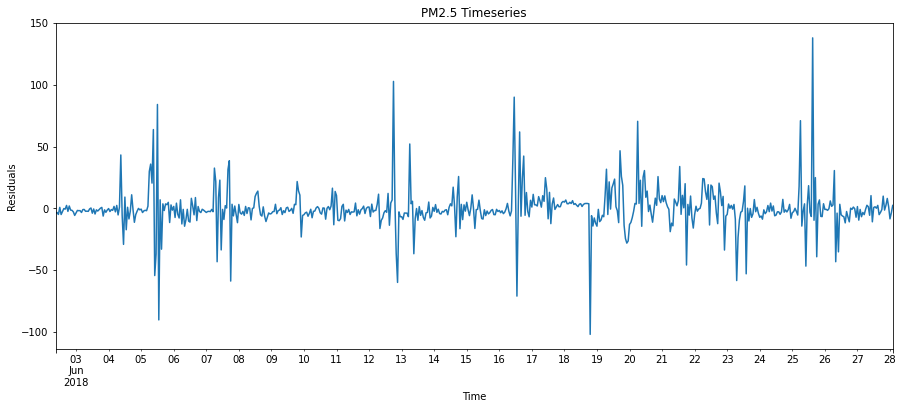

In [68]:
# plot line graph of residual
fig, ax  = plt.subplots(figsize=(15,6))
y_train_resid.plot(ax=ax, xlabel="Time", ylabel="Residuals", title="PM2.5 Timeseries");

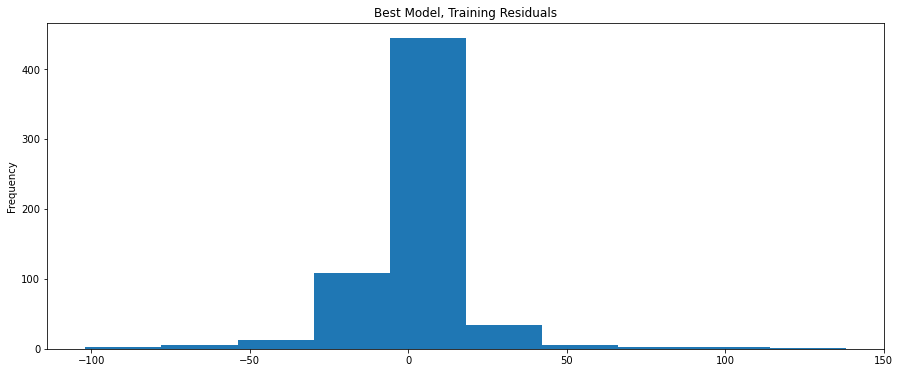

In [69]:
# plot histogram for residual
fig, ax  = plt.subplots(figsize=(15,6))
y_train_resid.plot(kind="hist",ax=ax, ylabel="Frequency", title="Best Model, Training Residuals");

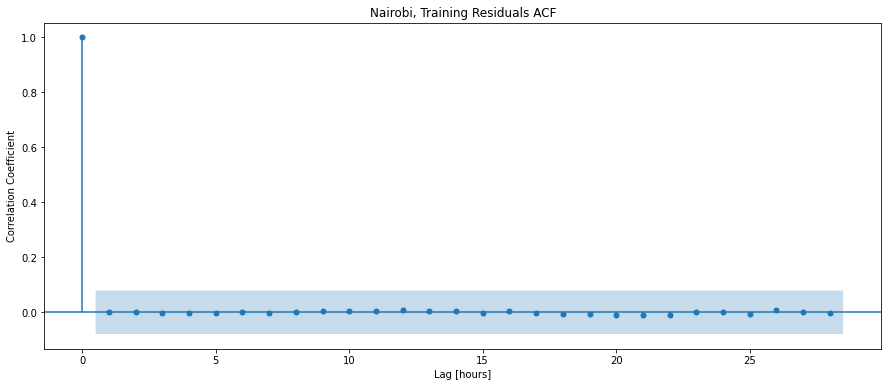

In [73]:
# Create an ACF plot for y_train_resid
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(y_train_resid,ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient")
plt.title("Nairobi, Training Residuals ACF");

## Evaluate

Perform walk-forward validation for your model for the entire test set `y_test`. Store your model's predictions in the Series `y_pred_wfv`. Make sure the name of your Series is `"prediction"` and the name of your Series index is `"timestamp"`.

In [75]:
y_pred_wfv = pd.Series() # store prediction 
history = y_train.copy() # store data to train AutoReg model, update at every loop
for i in range(len(y_test)):
    # initialize model
    model = AutoReg(history, lags=best_p).fit()
    # making prediction for next timestamp
    next_pred = model.forecast()
    # append forecast in y_pred_wfv
    y_pred_wfv = y_pred_wfv.append(next_pred)
    # update history by adding actual value for timestamp it just predicted to train model for next prediction.
    history = history.append(y_test[next_pred.index])
    
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()

timestamp
2018-06-28 03:00:00+03:00    32.348333
2018-06-28 04:00:00+03:00    30.723839
2018-06-28 05:00:00+03:00    34.645902
2018-06-28 06:00:00+03:00    35.349220
2018-06-28 07:00:00+03:00    33.803444
Freq: H, Name: prediction, dtype: float64

In [77]:
# Mean Absolute Error for your model
mae_test = mean_absolute_error(y_test, y_pred_wfv)
print("Mean Absolute Error:", round(mae_test,2))

Mean Absolute Error: 13.5


MAE for test set is far better than our baseline model(which shows it is a good model), however it is below our train's performance on best model(8.66).

# Communicate Result

Put the values for `y_test` and `y_pred_wfv` into the DataFrame `df_pred_test` (don't forget the index). Then plot `df_pred_test` using plotly express. Be sure to label the x-axis as `"Date"` and the y-axis as `"PM2.5 Level"`. Use the title `"Nairobi, WFV Predictions"`.

In [98]:
df_pred_test = pd.DataFrame(
    {
        "y_test":y_test,
        "y_pred_wfv":y_pred_wfv
    }, index = y_test.index
)
fig = px.line(df_pred_test)

fig.update_layout(
    title="Nairobi, WFV Prediction",
    xaxis_title="Date",
    yaxis_title="PM2.5 Level"
)